In [1]:
import hail as hl
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://admins-mbp:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.28-61941242c15d
LOGGING: writing to /Users/yanyul/Documents/repo/github/toy-example-of-hail-using-1kg/notebook/hail-20191212-2327-0.2.28-61941242c15d.log


In [2]:
import os
import numpy as np
from hail.plot import show
from pprint import pprint
from IPython.display import display
hl.plot.output_notebook()

Loading BokehJS ...

Download 1000G data using hail built-in function.

In [3]:
hl.utils.get_1kg('data/')

2019-12-12 23:27:25 Hail: INFO: 1KG files found


Read in the downloaded VCF file and write into MatrixTable format.

In [4]:
hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite = True)

2019-12-12 23:27:27 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:30 Hail: INFO: wrote matrix table with 10961 rows and 284 columns in 2 partitions to data/1kg.mt


In [5]:
mt = hl.read_matrix_table('data/1kg.mt')
variant = hl.read_table('output/variant_qc.ht')
mt = mt.filter_rows(hl.is_defined(variant[mt.locus, mt.alleles]))

Quick look at the genotype matrix.

In [6]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
----------------------------------------
Entry fields:
    'GT': call
    'AD': array<int32>
    'DP': int32
    'GQ': int32
    'PL': array<int32>
----------------------------------------
Colu

Simulate effect sizes for N traits and simulate K covariates.

In [7]:
Ntrait = 20
Kcovar = 5
frac_causal_high = 0.02
frac_causal_low = 0.0005
heribility = 0.1 # rough
nsnp = mt.count_rows()
nindiv = mt.count_cols()
snp_locus = mt.locus.collect()
snp_allele = mt.alleles.collect()
indiv_id = mt.s.collect()
af = np.array(variant.variant_qc.AF.collect())[:, 0]
varx = 2 * af * (1 - af)

In [8]:
varx.shape

(8777,)

In [9]:
# import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Let's define a function giving out simulated beta's and covariates 

In [10]:
def simulate_vector(length, frac_causal_range = None):
    if frac_causal_range is not None:
        frac_causal_low = min(frac_causal_range)
        frac_causal_high = max(frac_causal_range)
        ncausal = int(np.random.uniform(low = frac_causal_low, high = frac_causal_high, size = 1) * length)
    else:
        ncausal = length    
    nonzero_betas = np.random.uniform(low = -1, high = 1, size = ncausal)
    nonzero_idx = np.random.choice(range(length), size = ncausal, replace = False)
    betas = np.zeros([length])
    betas[nonzero_idx] = nonzero_betas
    plt = sns.scatterplot(x = range(length), y = betas)
    return betas, ncausal, plt
def simulate_error(length, se = 1):
    return np.random.normal(loc = 0, scale = se, size = length)

OK, let's simulate both $\beta$'s and covariates

In [11]:
# tmp[0].shape

In [12]:
# gene_var

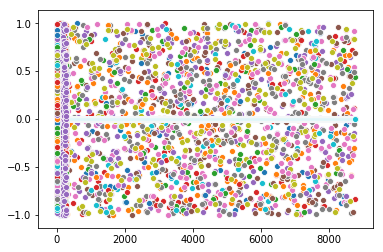

In [13]:
# for betas, it is by snp
effect_dic = {}
gene_var = {}
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    tmp = simulate_vector(nsnp, [frac_causal_low, frac_causal_high])
    effect_dic[trait_name] = tmp[0]
    nonzeros = tmp[0][tmp[0] != 0]
    varx_ = varx[tmp[0] != 0]
    gene_var[trait_name] = np.sum(nonzeros ** 2 * varx_)
effect_dic['locus'] = snp_locus
effect_dic['allele'] = snp_allele
df_effect = pd.DataFrame(effect_dic)

# for covariate, it loops over covariates
covar_dic = {}
for i in range(Kcovar):
    covar_name = f'covar_{i}'
    covar_dic[covar_name] = simulate_vector(nindiv)[0]
covar_dic['s'] = indiv_id
df_covar = pd.DataFrame(covar_dic)

# also, effect size of covariates for each trait
covar_eff_dic = {}
covar_eff_dic['covar_name'] = [ f'covar_{j}' for j in range(Kcovar) ]
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    covar_eff_dic[trait_name] = simulate_vector(Kcovar)[0]
df_covar_eff = pd.DataFrame(covar_eff_dic)

# also, intercept of each trait
intercept_dic = {}
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    intercept_dic[trait_name] = simulate_vector(1)[0]
df_intercept = pd.DataFrame(intercept_dic)
        
# at the end, we also want to simulate noise
noise_dic = {}
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    gene_var_ = gene_var[trait_name]
    error_var = gene_var_ / heribility - gene_var_
    noise_dic[trait_name] = simulate_error(nindiv, se = np.sqrt(error_var))
noise_dic['s'] = indiv_id
df_error = pd.DataFrame(noise_dic)

In [14]:
# ncausal[trait_name]

In [15]:
display(df_effect)
display(df_covar)
display(df_covar_eff)
display(df_intercept)
display(df_error)

,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,...,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19,locus,allele
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1:904165,"[G, A]"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1:1563691,"[T, G]"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1:1707740,"[T, G]"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1:2284195,"[T, C]"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1:2779043,"[T, C]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X:127348349,"[A, C]"
8773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X:130826305,"[C, T]"
8774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X:141495731,"[A, G]"
8775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X:141689987,"[A, C]"


,covar_0,covar_1,covar_2,covar_3,covar_4,s
0,-0.202462,0.030716,-0.546256,-0.217143,0.116609,HG00096
1,0.786324,-0.946181,0.284878,0.294803,-0.621831,HG00099
2,0.576343,0.056169,-0.966805,0.915390,0.352527,HG00105
3,-0.553596,0.294653,0.499798,0.699852,0.195304,HG00118
4,-0.698913,0.042565,0.498276,0.852347,-0.670959,HG00129
...,...,...,...,...,...,...
279,-0.949273,0.383674,0.651796,0.238329,0.669334,NA21114
280,0.282482,-0.039621,-0.715368,-0.182488,0.380270,NA21116
281,0.711629,-0.989505,0.721519,-0.233738,0.005083,NA21118
282,0.146762,0.296232,-0.727470,-0.104685,0.790040,NA21133


,covar_name,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,...,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
0,covar_0,-0.836881,-0.504087,0.265968,0.267508,0.435913,-0.449166,0.878405,0.084751,-0.779048,...,0.424364,-0.712689,0.635773,-0.209790,-0.486191,-0.043989,-0.001417,0.583635,-0.602796,-0.557627
1,covar_1,-0.315885,0.711931,0.982822,0.189218,0.571912,0.705340,0.307134,-0.679903,-0.080136,...,-0.762716,-0.703286,0.534806,-0.458573,-0.660016,0.870236,-0.232593,-0.351489,0.110894,0.038261
2,covar_2,0.226296,0.257968,0.928445,-0.552040,0.195029,-0.064474,-0.809422,-0.286553,0.503578,...,0.207503,0.716447,-0.836228,0.878316,0.733764,0.162731,0.207247,-0.445419,-0.291264,0.833318
3,covar_3,0.516878,-0.180377,0.133862,-0.955949,-0.342684,-0.105812,-0.183578,-0.907873,-0.762083,...,-0.315705,0.438768,-0.340650,0.855053,-0.944559,-0.350652,0.381288,0.755033,0.915531,0.699313
4,covar_4,0.052526,-0.515775,0.770487,0.486184,-0.551716,-0.114083,0.377134,0.883752,0.996472,...,0.837605,0.150550,-0.471006,0.708778,0.773248,0.383157,0.308014,0.902871,-0.429907,-0.102704


,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
0,-0.746081,0.925643,-0.645204,0.458315,-0.924426,0.929856,0.170151,-0.093342,0.145447,0.681877,0.067442,-0.441731,0.303451,0.664534,0.560127,0.873937,0.344557,-0.146254,0.388406,-0.747917


,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,...,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19,s
0,10.844753,-2.788994,-7.864833,10.771993,29.281528,18.544030,5.488091,3.805994,-0.049469,-6.840861,...,9.214655,3.353747,-2.879400,5.553565,-11.886491,-8.808800,18.691096,5.980702,7.786175,HG00096
1,-6.731098,3.858467,1.614132,18.772740,7.119392,-9.272077,16.041568,6.772274,-2.627378,-6.065470,...,16.167202,2.063783,-5.791290,5.321466,-2.254045,16.502985,-2.817588,41.102749,-1.371239,HG00099
2,2.043503,-4.931152,-1.751460,-10.399098,-16.622536,-6.039618,7.865226,3.777261,-13.011067,-1.085529,...,-5.586751,-9.512551,5.768877,-0.462957,5.872467,9.949723,-2.091315,1.592952,-3.767264,HG00105
3,16.182352,-0.665235,2.275338,-11.831882,-16.128112,-17.106375,7.656666,4.926855,1.236444,0.810821,...,-6.193683,-8.682005,7.845121,-3.332532,12.598206,5.068821,-8.517024,-8.463034,-4.763099,HG00118
4,0.423896,6.502130,8.605718,8.567945,3.070688,20.617174,13.756706,-1.713885,-5.019965,-3.881068,...,7.090086,6.204564,7.557090,-4.792222,-9.118583,-22.858528,15.771525,27.937916,-1.974241,HG00129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,-6.741045,3.476843,-9.672750,10.623707,16.855029,-3.680026,-4.186237,5.336879,5.356303,-12.091966,...,8.511720,0.052347,-3.481095,4.104517,-2.025368,-16.905449,14.974766,-11.344909,0.397657,NA21114
280,-6.077067,3.773416,3.763551,15.320947,-22.010269,3.893865,-5.568404,0.173591,-4.929807,10.896374,...,-1.646300,-6.987514,-4.549819,-0.174581,1.669988,11.155997,-12.067629,13.942484,-3.219549,NA21116
281,6.611065,3.820965,-0.228057,10.092250,7.111567,9.823707,3.672819,1.516661,12.321278,8.296597,...,7.342520,9.073543,3.872887,10.901367,-7.317672,-11.317030,-14.403619,-5.538532,1.526934,NA21118
282,6.276796,1.129089,-1.301296,4.496743,-8.089728,5.687000,5.792928,1.721841,-1.327300,11.557568,...,2.440938,-0.612594,-3.466167,-13.498585,-0.631876,6.549724,-3.933664,-23.589033,1.292329,NA21133


Now, let's compute effect of covariates on each trait and each individual.
To do so, let's convert these effect size and covariates data frames to hail format `Table` and `MatrixTable`.
Basically, we'd like to do: 
* We have `indiv x covar` matrix and `covar x trait` matrix
* For each individual, multiply covariate with the covariate effect size and add them up
* It means Einstein summation aggregating over covar

In [16]:
# convert indiv x covar to MatrixTable
# if not os.path.exists('output/indiv_covar.mt'):
(hl.Table
 .from_pandas(pd.melt(df_covar, id_vars=['s']).rename(columns = {'variable' : 'covar'}))
 .to_matrix_table(row_key = ['s'], col_key = ['covar'])
).write('output/indiv_covar.mt', overwrite = True)
indiv_covar = hl.read_matrix_table('output/indiv_covar.mt')
display(indiv_covar.describe())

# convert covar x trait to Table
# if not os.path.exists('output/covar_trait.ht'):
(hl.Table
.from_pandas(df_covar_eff.rename(columns = {'covar_name' : 'covar'}), key = ['covar'])  # pd.melt(df_covar_eff, id_vars=['covar_name']).rename(columns = {'covar_name' : 'covar', 'variable' : 'trait'}))
#     .to()
).write('output/covar_trait.ht', overwrite = True)
covar_trait = hl.read_table('output/covar_trait.ht')
display(covar_trait.describe())

2019-12-12 23:27:38 Hail: INFO: Ordering unsorted dataset with network shuffle


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'covar': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'value': float64
----------------------------------------
Column key: ['covar']
Row key: ['s']
----------------------------------------


2019-12-12 23:27:39 Hail: INFO: wrote matrix table with 284 rows and 5 columns in 8 partitions to output/indiv_covar.mt


None

2019-12-12 23:27:39 Hail: INFO: Coerced sorted dataset


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'covar': str 
    'trait_0': float64 
    'trait_1': float64 
    'trait_2': float64 
    'trait_3': float64 
    'trait_4': float64 
    'trait_5': float64 
    'trait_6': float64 
    'trait_7': float64 
    'trait_8': float64 
    'trait_9': float64 
    'trait_10': float64 
    'trait_11': float64 
    'trait_12': float64 
    'trait_13': float64 
    'trait_14': float64 
    'trait_15': float64 
    'trait_16': float64 
    'trait_17': float64 
    'trait_18': float64 
    'trait_19': float64 
----------------------------------------
Key: ['covar']
----------------------------------------


2019-12-12 23:27:39 Hail: INFO: wrote table with 5 rows in 5 partitions to output/covar_trait.ht


None

In [17]:
# ok, let's do the calculation
# 1. annotate indiv x covar with trait effect size
# 2. aggregate 
indiv_covar = indiv_covar.annotate_cols(trait_agg = covar_trait[indiv_covar.covar])
indiv_covar.describe()
indiv_covar.entry.show()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'covar': str
    'trait_agg': struct {
        trait_0: float64, 
        trait_1: float64, 
        trait_2: float64, 
        trait_3: float64, 
        trait_4: float64, 
        trait_5: float64, 
        trait_6: float64, 
        trait_7: float64, 
        trait_8: float64, 
        trait_9: float64, 
        trait_10: float64, 
        trait_11: float64, 
        trait_12: float64, 
        trait_13: float64, 
        trait_14: float64, 
        trait_15: float64, 
        trait_16: float64, 
        trait_17: float64, 
        trait_18: float64, 
        trait_19: float64
    }
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'value': float64
----------------------------------------
Column key: ['covar']
Row key: ['s']
----------------------------------------


s,covar_0.value,covar_1.value,covar_2.value,covar_3.value,covar_4.value
str,float64,float64,float64,float64,float64
"""HG00096""",-2.02e-01,3.07e-02,-5.46e-01,-2.17e-01,1.17e-01
"""HG00099""",7.86e-01,-9.46e-01,2.85e-01,2.95e-01,-6.22e-01
"""HG00105""",5.76e-01,5.62e-02,-9.67e-01,9.15e-01,3.53e-01
"""HG00118""",-5.54e-01,2.95e-01,5.00e-01,7.00e-01,1.95e-01
"""HG00129""",-6.99e-01,4.26e-02,4.98e-01,8.52e-01,-6.71e-01
"""HG00148""",-9.75e-01,-6.39e-01,-2.72e-01,-1.94e-01,-1.40e-01
"""HG00177""",4.57e-01,1.37e-01,-1.46e-01,-6.01e-01,-3.24e-01
"""HG00182""",-1.38e-01,6.11e-01,6.67e-01,3.33e-01,5.38e-01
"""HG00242""",4.18e-01,-4.55e-01,3.75e-01,-7.19e-01,8.64e-04


In [18]:
expr_ = {
    k : hl.agg.sum(indiv_covar.trait_agg[k] * indiv_covar.value)
    for k in list(indiv_covar.trait_agg.keys())
}
indiv_covar = indiv_covar.annotate_rows(**expr_)

In [19]:
indiv_idx = 10
trait_idx = 20
this_re = indiv_covar.rows().to_pandas().iloc[[indiv_idx - 1], [trait_idx]]
print('sanity check')
a = df_covar_eff.iloc[:, [trait_idx]]
b = df_covar.iloc[[indiv_idx - 1], : (df_covar.shape[1] - 1)]
alter_re = np.sum(np.array(b) * np.array(a).transpose())
print('if this == alter ? ', this_re.to_numpy() == alter_re)

sanity check
if this == alter ?  [[ True]]


OK, it works. Now that we need to repeat the similar procedure to compute the genetic effect. 
Let's organize what we have and see how we can do it.
* We have `snp x trait` matrix and `snp x indiv` matrix
* We can annotate rows of `snp x indiv` with effect size of SNPs
* And then, do the calculation

In [20]:
df_effect['new'] = df_effect[['locus', 'allele']].apply(lambda x: str(x[0]) + ':' + x[1][0] + ':' + x[1][1], axis = 1)

In [21]:
# convert snp x trait matrix to Table 
# I got a hard time using from_pandas so that I did the work around as follow
df_effect.to_csv('output/snp_trait.tsv', sep = '\t', index = False)
tdic = { f'trait_{i}' : hl.tfloat for i in range(Ntrait) }
snp_trait = hl.import_table('output/snp_trait.tsv', types = tdic)
# some ugly formatting
snp_trait_new = snp_trait.annotate(a = hl.parse_variant(snp_trait.new))
snp_trait_new = snp_trait_new.drop('locus', 'allele', 'new')
snp_trait_new = snp_trait_new.flatten().rename({'a.locus': 'locus', 'a.alleles' : 'alleles'})
snp_trait = snp_trait_new
snp_trait = snp_trait.key_by(snp_trait.locus, snp_trait.alleles)
snp_trait.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'trait_0': float64 
    'trait_1': float64 
    'trait_2': float64 
    'trait_3': float64 
    'trait_4': float64 
    'trait_5': float64 
    'trait_6': float64 
    'trait_7': float64 
    'trait_8': float64 
    'trait_9': float64 
    'trait_10': float64 
    'trait_11': float64 
    'trait_12': float64 
    'trait_13': float64 
    'trait_14': float64 
    'trait_15': float64 
    'trait_16': float64 
    'trait_17': float64 
    'trait_18': float64 
    'trait_19': float64 
    'locus': locus<GRCh37> 
    'alleles': array<str> 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


2019-12-12 23:27:42 Hail: INFO: Reading table with no type imputation
  Loading column 'trait_0' as type 'float64' (user-specified)
  Loading column 'trait_1' as type 'float64' (user-specified)
  Loading column 'trait_2' as type 'float64' (user-specified)
  Loading column 'trait_3' as type 'float64' (user-specified)
  Loading column 'trait_4' as type 'float64' (user-specified)
  Loading column 'trait_5' as type 'float64' (user-specified)
  Loading column 'trait_6' as type 'float64' (user-specified)
  Loading column 'trait_7' as type 'float64' (user-specified)
  Loading column 'trait_8' as type 'float64' (user-specified)
  Loading column 'trait_9' as type 'float64' (user-specified)
  Loading column 'trait_10' as type 'float64' (user-specified)
  Loading column 'trait_11' as type 'float64' (user-specified)
  Loading column 'trait_12' as type 'float64' (user-specified)
  Loading column 'trait_13' as type 'float64' (user-specified)
  Loading column 'trait_14' as type 'float64' (user-specif

In [22]:
mt = mt.annotate_rows(genetic_eff = snp_trait[mt.locus, mt.alleles])
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
    'genetic_eff': struct {
        trait_0: float64, 
        trait_1: float64, 
        trait_2: float64, 
        trait_3: float64, 
        trait_4: float64, 
        trait_5: float64, 
   

In [23]:
expr_ = {
    k : hl.agg.sum(mt.genetic_eff[k] * mt.GT.n_alt_alleles())
    for k in list(mt.genetic_eff.keys())
}

In [24]:
mt = mt.annotate_cols(**expr_)

Now that we have both genetic effect and covariates effect by individuals. 

In [25]:
display(indiv_covar.row.show(3))
display(mt.col.show(3))

s,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",-7.00e-02,-3.80e-02,-4.70e-01,5.17e-01,-1.67e-01,1.57e-01,3.58e-01,4.19e-01,1.62e-01,2.27e-03,-5.65e-02,-3.46e-01,3.64e-01,-5.54e-01,-2.74e-02,6.76e-02,-1.67e-01,5.57e-02,3.56e-02,-5.05e-01
"""HG00099""",-1.75e-01,-7.29e-01,-8.96e-01,-7.10e-01,9.92e-02,-9.99e-01,-1.19e-01,-1.89e-01,-1.24e+00,-1.07e+00,5.01e-01,3.45e-01,-5.19e-02,3.30e-01,-3.08e-01,-1.15e+00,1.99e-01,3.26e-01,-1.25e-01,3.27e-02
"""HG00105""",-2.27e-01,-8.47e-01,-2.95e-01,-5.15e-03,-4.13e-01,-2.94e-01,1.27e+00,-2.32e-01,-1.29e+00,-1.86e+00,7.41e-03,-6.88e-01,7.27e-01,3.67e-02,-1.62e+00,-3.20e-01,2.43e-01,1.76e+00,6.27e-01,-5.21e-01


None

2019-12-12 23:27:43 Hail: INFO: Coerced sorted dataset


s,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",3.57e+00,-2.20e+00,-2.70e+00,-4.43e-01,3.20e+00,-4.23e+00,4.58e+00,8.34e+00,5.94e+00,-2.44e+00,-1.25e-01,-1.57e+00,1.04e+01,-6.11e+00,5.78e+00,-3.37e-01,-2.73e+00,-3.45e-01,1.22e+01,-8.58e-01
"""HG00099""",-8.91e-01,7.07e-01,-6.80e+00,-4.58e+00,3.28e+00,-1.19e+01,4.88e+00,-2.84e+00,3.39e+00,1.15e-01,2.83e-01,-9.48e+00,8.39e+00,-2.37e+00,3.48e+00,-4.07e+00,5.44e+00,-1.38e+00,4.77e+00,-9.92e-01
"""HG00105""",2.79e+00,7.50e-01,-3.72e+00,-1.22e+01,-2.38e+00,-4.93e+00,-3.92e+00,7.03e+00,1.98e+00,3.98e-01,-4.31e+00,-5.32e+00,1.36e+00,-5.86e+00,2.42e-01,2.12e+00,4.31e+00,4.41e+00,1.41e+01,1.83e+00


None

The missing ingrediant is the intercept table and error table.

In [26]:
# intercept table
tmp = list(df_intercept.transpose().index)
df_intercept = df_intercept.transpose()
df_intercept['trait'] = tmp
df_intercept = df_intercept.rename(columns = {0 : 'intercept'})
# display(df_intercept.head())
hl.Table.from_pandas(df_intercept, key = ['trait']).write('output/trait_intercept.ht', overwrite = True)
trait_intercept = hl.read_table('output/trait_intercept.ht')
trait_intercept.describe()

2019-12-12 23:27:45 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:45 Hail: INFO: Coerced dataset with out-of-order partitions.


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'intercept': float64 
    'trait': str 
----------------------------------------
Key: ['trait']
----------------------------------------


2019-12-12 23:27:45 Hail: INFO: wrote table with 20 rows in 8 partitions to output/trait_intercept.ht


In [27]:
df_error

,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,...,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19,s
0,10.844753,-2.788994,-7.864833,10.771993,29.281528,18.544030,5.488091,3.805994,-0.049469,-6.840861,...,9.214655,3.353747,-2.879400,5.553565,-11.886491,-8.808800,18.691096,5.980702,7.786175,HG00096
1,-6.731098,3.858467,1.614132,18.772740,7.119392,-9.272077,16.041568,6.772274,-2.627378,-6.065470,...,16.167202,2.063783,-5.791290,5.321466,-2.254045,16.502985,-2.817588,41.102749,-1.371239,HG00099
2,2.043503,-4.931152,-1.751460,-10.399098,-16.622536,-6.039618,7.865226,3.777261,-13.011067,-1.085529,...,-5.586751,-9.512551,5.768877,-0.462957,5.872467,9.949723,-2.091315,1.592952,-3.767264,HG00105
3,16.182352,-0.665235,2.275338,-11.831882,-16.128112,-17.106375,7.656666,4.926855,1.236444,0.810821,...,-6.193683,-8.682005,7.845121,-3.332532,12.598206,5.068821,-8.517024,-8.463034,-4.763099,HG00118
4,0.423896,6.502130,8.605718,8.567945,3.070688,20.617174,13.756706,-1.713885,-5.019965,-3.881068,...,7.090086,6.204564,7.557090,-4.792222,-9.118583,-22.858528,15.771525,27.937916,-1.974241,HG00129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,-6.741045,3.476843,-9.672750,10.623707,16.855029,-3.680026,-4.186237,5.336879,5.356303,-12.091966,...,8.511720,0.052347,-3.481095,4.104517,-2.025368,-16.905449,14.974766,-11.344909,0.397657,NA21114
280,-6.077067,3.773416,3.763551,15.320947,-22.010269,3.893865,-5.568404,0.173591,-4.929807,10.896374,...,-1.646300,-6.987514,-4.549819,-0.174581,1.669988,11.155997,-12.067629,13.942484,-3.219549,NA21116
281,6.611065,3.820965,-0.228057,10.092250,7.111567,9.823707,3.672819,1.516661,12.321278,8.296597,...,7.342520,9.073543,3.872887,10.901367,-7.317672,-11.317030,-14.403619,-5.538532,1.526934,NA21118
282,6.276796,1.129089,-1.301296,4.496743,-8.089728,5.687000,5.792928,1.721841,-1.327300,11.557568,...,2.440938,-0.612594,-3.466167,-13.498585,-0.631876,6.549724,-3.933664,-23.589033,1.292329,NA21133


In [28]:
(hl.Table
 .from_pandas(pd.melt(df_error, id_vars=['s']).rename(columns = {'variable': 'trait'}))
 .to_matrix_table(row_key = ['s'], col_key = ['trait'])
)

In [29]:
# error table
(hl.Table
 .from_pandas(pd.melt(df_error, id_vars=['s']).rename(columns = {'variable': 'trait'}))
 .to_matrix_table(row_key = ['s'], col_key = ['trait'])
).write('output/indiv_trait_error.mt', overwrite = True)
indiv_trait_error = hl.read_matrix_table('output/indiv_trait_error.mt')
display(indiv_trait_error.describe())

2019-12-12 23:27:47 Hail: INFO: Ordering unsorted dataset with network shuffle


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'trait': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'value': float64
----------------------------------------
Column key: ['trait']
Row key: ['s']
----------------------------------------


2019-12-12 23:27:47 Hail: INFO: wrote matrix table with 284 rows and 20 columns in 8 partitions to output/indiv_trait_error.mt


None

OK, eventuallly, we have all the ingredients! They are covariates effects, genetic effects, and trait intercept.

In [30]:
covar_eff = indiv_covar.rows().key_by('s').to_matrix_table_row_major(columns = [f'trait_{i}' for i in range(20)], entry_field_name = 'covar_eff', col_field_name = 'trait')
genetic_eff = mt.cols().key_by('s').to_matrix_table_row_major(columns = [f'trait_{i}' for i in range(20)], entry_field_name = 'genetic_eff', col_field_name = 'trait')

2019-12-12 23:27:47 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [31]:
covar_eff.describe()
genetic_eff.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'trait': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'covar_eff': float64
----------------------------------------
Column key: ['trait']
Row key: ['s']
----------------------------------------
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'trait': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'genetic_eff': float64
----------------------------------------
Column key: ['trait']
Row key: ['s']
----------------------------------------


In [32]:
phenotype = covar_eff
phenotype = phenotype.annotate_entries(genetic_eff = genetic_eff[phenotype.s, phenotype.trait].genetic_eff)
phenotype = phenotype.annotate_entries(error = indiv_trait_error[phenotype.s, phenotype.trait].value)
phenotype = phenotype.annotate_cols(intercept = trait_intercept[phenotype.trait].intercept)

In [33]:
def add_all(x):
    out = 0
    for i in x:
        out += i
    return out

In [34]:
phenotype = phenotype.annotate_entries(pheno = add_all([phenotype.covar_eff, phenotype.genetic_eff, phenotype.intercept, phenotype.error]))

In [35]:
phenotype.genetic_eff.show(3)
phenotype.error.show(3)
phenotype.covar_eff.show(3)
phenotype.intercept.show(3)
phenotype.pheno.show(3)

2019-12-12 23:27:49 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:50 Hail: INFO: Coerced sorted dataset


s,trait_0.genetic_eff,trait_1.genetic_eff,trait_2.genetic_eff,trait_3.genetic_eff,trait_4.genetic_eff,trait_5.genetic_eff,trait_6.genetic_eff,trait_7.genetic_eff
str,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",3.57e+00,-2.20e+00,-2.70e+00,-4.43e-01,3.20e+00,-4.23e+00,4.58e+00,8.34e+00
"""HG00099""",-8.91e-01,7.07e-01,-6.80e+00,-4.58e+00,3.28e+00,-1.19e+01,4.88e+00,-2.84e+00
"""HG00105""",2.79e+00,7.50e-01,-3.72e+00,-1.22e+01,-2.38e+00,-4.93e+00,-3.92e+00,7.03e+00


s,trait_0.error,trait_1.error,trait_2.error,trait_3.error,trait_4.error,trait_5.error,trait_6.error,trait_7.error,trait_8.error,trait_9.error
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",1.08e+01,-2.79e+00,-7.86e+00,1.08e+01,2.93e+01,1.85e+01,5.49e+00,3.81e+00,-4.95e-02,-6.84e+00
"""HG00099""",-6.73e+00,3.86e+00,1.61e+00,1.88e+01,7.12e+00,-9.27e+00,1.60e+01,6.77e+00,-2.63e+00,-6.07e+00
"""HG00105""",2.04e+00,-4.93e+00,-1.75e+00,-1.04e+01,-1.66e+01,-6.04e+00,7.87e+00,3.78e+00,-1.30e+01,-1.09e+00


s,trait_0.covar_eff,trait_1.covar_eff,trait_2.covar_eff,trait_3.covar_eff,trait_4.covar_eff,trait_5.covar_eff,trait_6.covar_eff,trait_7.covar_eff,trait_8.covar_eff
str,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",-7.00e-02,-3.80e-02,-4.70e-01,5.17e-01,-1.67e-01,1.57e-01,3.58e-01,4.19e-01,1.62e-01
"""HG00099""",-1.75e-01,-7.29e-01,-8.96e-01,-7.10e-01,9.92e-02,-9.99e-01,-1.19e-01,-1.89e-01,-1.24e+00
"""HG00105""",-2.27e-01,-8.47e-01,-2.95e-01,-5.15e-03,-4.13e-01,-2.94e-01,1.27e+00,-2.32e-01,-1.29e+00


trait,intercept
str,float64
"""trait_0""",-7.46e-01
"""trait_1""",9.26e-01
"""trait_2""",-6.45e-01


2019-12-12 23:27:54 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:55 Hail: INFO: Coerced sorted dataset


s,trait_0.pheno,trait_1.pheno,trait_2.pheno,trait_3.pheno,trait_4.pheno,trait_5.pheno,trait_6.pheno,trait_7.pheno,trait_8.pheno,trait_9.pheno
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",1.36e+01,-4.10e+00,-1.17e+01,1.13e+01,3.14e+01,1.54e+01,1.06e+01,1.25e+01,6.20e+00,-8.60e+00
"""HG00099""",-8.54e+00,4.76e+00,-6.72e+00,1.39e+01,9.58e+00,-2.13e+01,2.10e+01,3.65e+00,-3.30e-01,-6.34e+00
"""HG00105""",3.86e+00,-4.10e+00,-6.41e+00,-2.21e+01,-2.03e+01,-1.03e+01,5.39e+00,1.05e+01,-1.22e+01,-1.86e+00


In [36]:
phenotype.pheno.export('output/indiv_pheno.tsv')
indiv_covar.value.export('output/indiv_covar.tsv')
covar_trait.export('output/covar_effect_size.tsv')
snp_trait.export('output/snp_effect_size.tsv')
indiv_trait_error.value.export('output/indiv_pheno_error.tsv')

2019-12-12 23:27:56 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:57 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:58 Hail: INFO: merging 9 files totalling 71.8K...
2019-12-12 23:27:58 Hail: INFO: while writing:
    output/indiv_pheno.tsv
  merge time: 20.502ms
2019-12-12 23:27:58 Hail: INFO: merging 9 files totalling 19.6K...
2019-12-12 23:27:58 Hail: INFO: while writing:
    output/indiv_covar.tsv
  merge time: 18.078ms
2019-12-12 23:27:58 Hail: INFO: merging 5 files totalling 1.3K...
2019-12-12 23:27:58 Hail: INFO: while writing:
    output/covar_effect_size.tsv
  merge time: 12.692ms
2019-12-12 23:27:59 Hail: INFO: Coerced sorted dataset
2019-12-12 23:27:59 Hail: INFO: merging 8 files totalling 2.0M...
2019-12-12 23:27:59 Hail: INFO: while writing:
    output/snp_effect_size.tsv
  merge time: 23.365ms
2019-12-12 23:27:59 Hail: INFO: merging 9 files totalling 71.7K...
2019-12-12 23:27:59 Hail: INFO: while writing:
    output/indiv_pheno_error.tsv
  merge time: 16.197ms
